In [16]:
import tensorflow as tf
from glob import glob
import numpy as np
import logging
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import h5py
import pickle
from sklearn.model_selection import KFold
from kerastuner import HyperModel, RandomSearch
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import json
from sklearn.metrics import mean_squared_error


from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape,  Dropout, Conv2DTranspose
from tensorflow.keras.models import Model


In [17]:
import umap

In [18]:
SEED = 42
VALIDATION_SPLIT= 0.3
TEST_SPLIT = 0.1

In [19]:
# Setup logger
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

In [20]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [128, 128])  # Resize images to 128x128
    return img / 255.0  # Normalize the images to [0, 1]

In [21]:


def load_occupancy_image_paths(data_folder):
    # List images
    occupied = glob(os.path.join(data_folder, "[!empty]*/*.png"))
    empty = glob(os.path.join(data_folder, "empty/*.png"))

    # Downsample the majority class
    rng = np.random.default_rng(seed=SEED)
    rng.shuffle(empty)
    empty = empty[:len(occupied)]

    print(f"Occupied samples: {len(occupied)}")
    print(f"Empty samples: {len(empty)}")

    # Combine paths
    paths = np.array(occupied + empty)
    return paths


In [22]:
data_folder = "/Users/ximenamoure/Desktop/drift_last/training_dataset"
all_image_paths = load_occupancy_image_paths(data_folder)

Occupied samples: 24116
Empty samples: 24116


In [23]:
""" # Split the data into training and validation sets
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.3, random_state=SEED)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) """

' # Split the data into training and validation sets\ntrain_paths, val_paths = train_test_split(all_image_paths, test_size=0.3, random_state=SEED)\n\n# Create TensorFlow datasets\ntrain_dataset = tf.data.Dataset.from_tensor_slices(train_paths)\ntrain_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)\ntrain_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)\n\nval_dataset = tf.data.Dataset.from_tensor_slices(val_paths)\nval_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)\nval_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) '

In [23]:
# Split the data into training, validation, and test sets
train_val_paths, test_paths = train_test_split(all_image_paths, test_size=TEST_SPLIT, random_state=SEED)
train_paths, val_paths = train_test_split(train_val_paths, test_size=VALIDATION_SPLIT, random_state=SEED)

In [24]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [27]:
class AutoencoderHyperModel(HyperModel):
    def build(self, hp):
        input_img = Input(shape=(128, 128, 3))

        # Encoder
        x = Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu', padding='same')(input_img)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
            kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(
            filters=hp.Int('filters_3', min_value=128, max_value=512, step=128),
            kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Flatten()(x)
        bottleneck = Dense(hp.Int('bottleneck_size', min_value=50, max_value=200, step=50), activation='relu', name='bottleneck')(x)
        bottleneck = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(bottleneck)  # Adding dropout

        # Decoder
        x = Dense(16 * 16 * hp.Int('filters_3', min_value=128, max_value=512, step=128), activation='relu')(bottleneck)
        x = Reshape((16, 16, hp.Int('filters_3', min_value=128, max_value=512, step=128)))(x)
        x = Conv2DTranspose(hp.Int('filters_3', min_value=128, max_value=512, step=128), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(hp.Int('filters_2', min_value=64, max_value=256, step=64), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                            loss='mse')
        return autoencoder

In [28]:
# Define the tuner
tuner = RandomSearch(
    AutoencoderHyperModel(),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v2',
    project_name='autoencoder_tuning')

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
bottleneck_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
tuner.search(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
filters_1 = best_hps.get('filters_1')
filters_2 = best_hps.get('filters_2')
filters_3 = best_hps.get('filters_3')
bottleneck_size = best_hps.get('bottleneck_size')
learning_rate = best_hps.get('learning_rate')

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first Conv2D layer is {filters_1},
the optimal number of filters in the second Conv2D layer is {filters_2},
the optimal number of filters in the third Conv2D layer is {filters_3},
the optimal bottleneck size is {bottleneck_size},
and the optimal learning rate for the optimizer is {learning_rate}.
""")

Trial 5 Complete [00h 41m 19s]
val_loss: 0.004207706544548273

Best val_loss So Far: 0.0018826936720870435
Total elapsed time: 05h 10m 19s

The hyperparameter search is complete. The optimal number of filters in the first Conv2D layer is 96,
the optimal number of filters in the second Conv2D layer is 64,
the optimal number of filters in the third Conv2D layer is 256,
the optimal bottleneck size is 150,
and the optimal learning rate for the optimizer is 0.0001.



In [31]:
best_hps_dict = {
    'filters_1': best_hps.get('filters_1'),
    'filters_2': best_hps.get('filters_2'),
    'filters_3': best_hps.get('filters_3'),
    'bottleneck_size': best_hps.get('bottleneck_size'),
    'learning_rate': best_hps.get('learning_rate')
}

# Save the hyperparameters to a JSON file
with open('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v2/best_hyperparameters.json', 'w') as json_file:
    json.dump(best_hps_dict, json_file)

In [32]:
EPOCHS = 10

def create_autoencoder(filters_1, filters_2, filters_3, bottleneck_size, learning_rate, dropout_rate=0.3):
    input_img = Input(shape=(128, 128, 3))

    # Encoder
    x = Conv2D(filters=filters_1, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(filters=filters_2, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(filters=filters_3, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    bottleneck = Dense(bottleneck_size, activation='relu', name='bottleneck')(x)
    bottleneck = Dropout(dropout_rate)(bottleneck)  # Adding dropout for regularization

    # Decoder
    x = Dense(16 * 16 * filters_3, activation='relu')(bottleneck)
    x = Reshape((16, 16, filters_3))(x)
    x = Conv2DTranspose(filters_3, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(filters_2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(filters_1, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return autoencoder



In [33]:
# Define the K-Fold Cross-Validation Function
def perform_k_fold_cross_validation(paths, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    all_scores = []
    training_losses = []
    validation_losses = []
    best_autoencoder = None
    best_val_loss = float('inf')

    for fold, (train_index, val_index) in enumerate(kf.split(paths)):
        print(f"Training on fold {fold+1}...")
        train_paths, val_paths = paths[train_index], paths[val_index]

        # Create TensorFlow datasets
        train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
        train_ds = train_ds.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
        val_ds = val_ds.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

        # Create the autoencoder model with the best hyperparameters
        autoencoder = create_autoencoder(filters_1, filters_2, filters_3, bottleneck_size, learning_rate)

        # Train the model
        history = autoencoder.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

        # Get the validation loss from the last epoch
        val_loss = history.history['val_loss'][-1]
        all_scores.append(val_loss)

        # Capture training and validation losses for plotting
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        # Track the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_autoencoder = autoencoder

    print(f'Cross-Validation Scores: {all_scores}')
    print(f'Mean Validation Loss: {np.mean(all_scores)}')

    # Plot training and validation losses
    plt.figure(figsize=(12, 6))
    for i in range(k):
        plt.plot(training_losses[i], label=f'Training Loss Fold {i+1}')
        plt.plot(validation_losses[i], label=f'Validation Loss Fold {i+1}', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses Across Folds')
    plt.show()

    return best_autoencoder


Training on fold 1...


Epoch 1/10


2024-08-27 16:29:43.995111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0085

2024-08-27 16:32:55.355698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 207s 190ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 2/10
1086/1086 [==============================] - 207s 191ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/10
1086/1086 [==============================] - 198s 182ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/10
1086/1086 [==============================] - 206s 190ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/10
1086/1086 [==============================] - 207s 190ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/10
1086/1086 [==============================] - 205s 189ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/10
1086/1086 [==============================] - 204s 188ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/10
1086/1086 [==============================] - 

Training on fold 2...
Epoch 1/10


2024-08-27 17:03:39.028063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0085

2024-08-27 17:06:48.862516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 205s 188ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 2/10
1086/1086 [==============================] - 207s 190ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/10
1086/1086 [==============================] - 202s 186ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/10
1086/1086 [==============================] - 208s 191ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/10
1086/1086 [==============================] - 204s 188ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
1086/1086 [==============================] - 206s 190ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/10
1086/1086 [==============================] - 206s 189ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/10
1086/1086 [==============================] - 198s 183ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 10/10
1086/1086 [==============================] - 

Training on fold 3...
Epoch 1/10


2024-08-27 17:37:36.508214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0087

2024-08-27 17:40:39.430125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 198s 181ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 2/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/10
1086/1086 [==============================] - 196s 181ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/10
1086/1086 [==============================] - 189s 174ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/10
1086/1086 [==============================] - 196s 181ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/10
1086/1086 [==============================] - 199s 184ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/10
1086/1086 [==============================] - 188s 173ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/10
1086/1086 [==============================] - 193s 178ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/10
1086/1086 [==============================] - 

Training on fold 4...
Epoch 1/10


2024-08-27 18:10:11.575412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0086

2024-08-27 18:13:12.800087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 197s 181ms/step - loss: 0.0086 - val_loss: 0.0041
Epoch 2/10
1086/1086 [==============================] - 198s 182ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/10
1086/1086 [==============================] - 203s 187ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 4/10
1086/1086 [==============================] - 190s 175ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/10
1086/1086 [==============================] - 202s 186ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
1086/1086 [==============================] - 202s 186ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/10
1086/1086 [==============================] - 195s 180ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/10
1086/1086 [==============================] - 

Training on fold 5...
Epoch 1/10


2024-08-27 18:43:18.897126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0090

2024-08-27 18:46:24.528723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 201s 184ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 2/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 3/10
1086/1086 [==============================] - 205s 189ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/10
1086/1086 [==============================] - 204s 188ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10
1086/1086 [==============================] - 201s 185ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/10
1086/1086 [==============================] - 199s 183ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/10
1086/1086 [==============================] - 198s 182ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/10
1086/1086 [==============================] - 

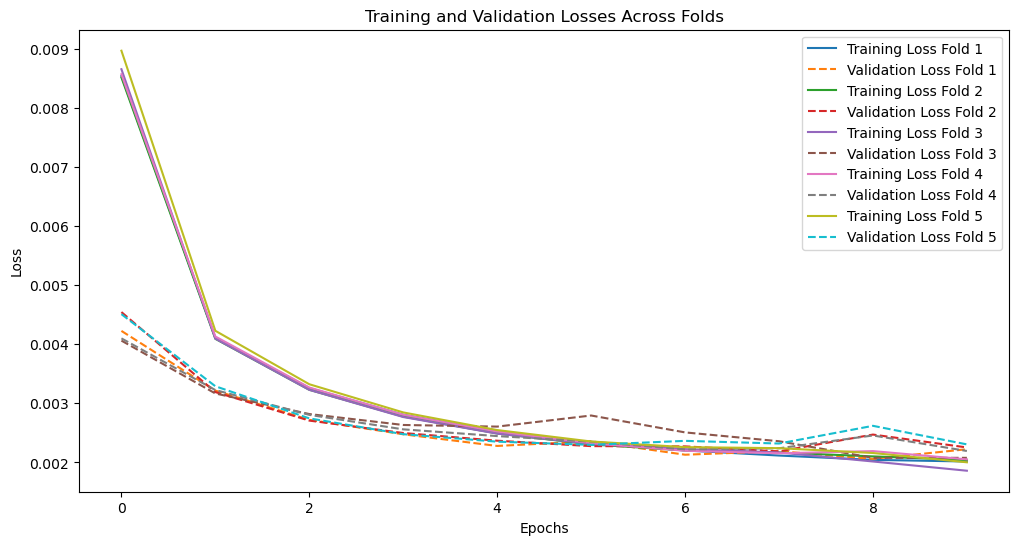

In [34]:
# Perform K-Fold Cross-Validation and get the best autoencoder model
best_autoencoder = perform_k_fold_cross_validation(train_val_paths, k=5)

In [35]:
best_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 96)      2688      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 96)      384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        55360     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256 

In [36]:
# Define the encoder model using the best autoencoder model
encoder = tf.keras.models.Model(inputs=best_autoencoder.input, outputs=best_autoencoder.get_layer('bottleneck').output)

In [37]:
best_autoencoder.save('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v2/autoencoder_model.h5')

/Users/ximenamoure/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Calculate and store the baseline reconstruction error
baseline_losses = []
for batch in train_dataset:
    # Assuming train_dataset yields tuples (input, target)
    input_images, _ = batch  # Ignore the labels if any
    preds = best_autoencoder.predict(input_images)
    loss = mean_squared_error(input_images.numpy().flatten(), preds.flatten())
    baseline_losses.append(loss)

baseline_loss = np.mean(baseline_losses)

with open('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v2/baseline_loss.pkl', 'wb') as f:
    pickle.dump(baseline_loss, f)

1/1 [==============================] - 0s 198ms/step


2024-08-27 19:24:48.644245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [42]:
# Evaluate the final model on the separate test set
test_loss = best_autoencoder.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')

151/151 [==============================] - 9s 57ms/step - loss: 0.0021
Test Loss: 0.0021487181074917316


In [38]:

encoder.save('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v2/encoder_model.h5')

In [43]:
combined_dataset = train_dataset.concatenate(val_dataset)

1/1 [==============================] - 0s 94ms/step


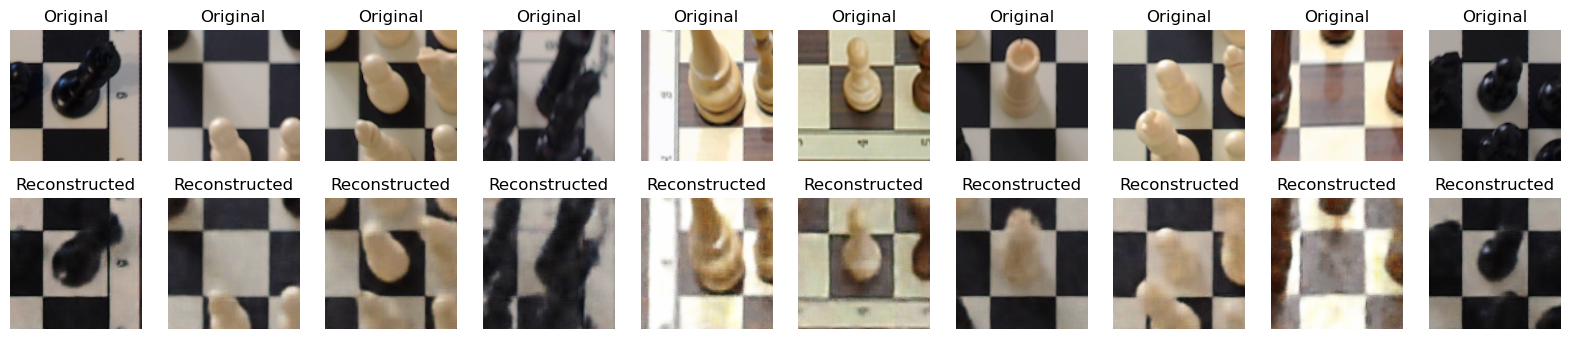

In [44]:
def plot_reconstructions(model, dataset, n=10):
    # Get a batch of images from the dataset
    batch = next(iter(dataset))
    images = batch[0][:n]  # Get the first n images

    # Get the reconstructed images
    reconstructed_images = model.predict(images)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Plot the original and reconstructed images
plot_reconstructions(best_autoencoder, combined_dataset)


1/1 [==============================] - 0s 162ms/step


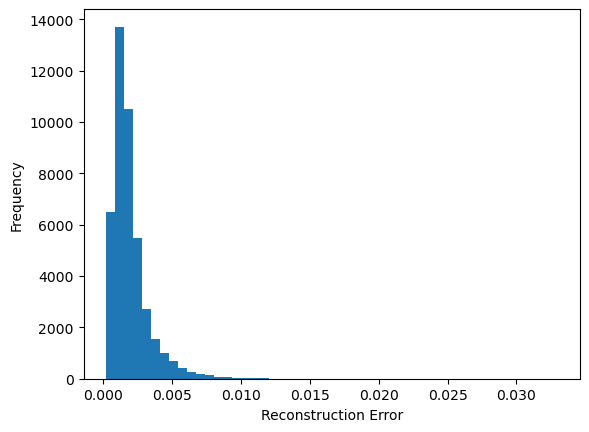

In [45]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(model, dataset):
    errors = []
    for batch in dataset:
        images = batch[0]
        reconstructed_images = model.predict(images)
        mse = np.mean(np.square(images.numpy() - reconstructed_images), axis=(1, 2, 3))
        errors.extend(mse)
    return np.array(errors)

# Calculate reconstruction error for the baseline dataset
reconstruction_errors = calculate_reconstruction_error(best_autoencoder, combined_dataset)

# Plot the reconstruction error
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


In [46]:
# Identify high error samples
high_error_threshold = np.percentile(reconstruction_errors, 95)  # Top 5% highest errors
high_error_indices = np.where(reconstruction_errors > high_error_threshold)[0]

print(f"Number of high error samples: {len(high_error_indices)}")

Number of high error samples: 2171


In [47]:
# Function to extract high error images from the dataset
def extract_high_error_images(dataset, high_error_indices, n=10):
    high_error_images = []
    counter = 0

    for batch in dataset:
        images = batch[0].numpy()
        for idx in high_error_indices:
            if counter < n and idx < images.shape[0]:
                high_error_images.append(images[idx])
                counter += 1
        if counter >= n:
            break

    return np.array(high_error_images)


In [48]:
# Extract high error images
high_error_images = extract_high_error_images(combined_dataset, high_error_indices, n=10)

# Ensure high_error_images has the correct shape
high_error_images = high_error_images.reshape(-1, 128, 128, 3)

# Get the reconstructed images
reconstructed_images = best_autoencoder.predict(high_error_images)


1/1 [==============================] - 0s 206ms/step


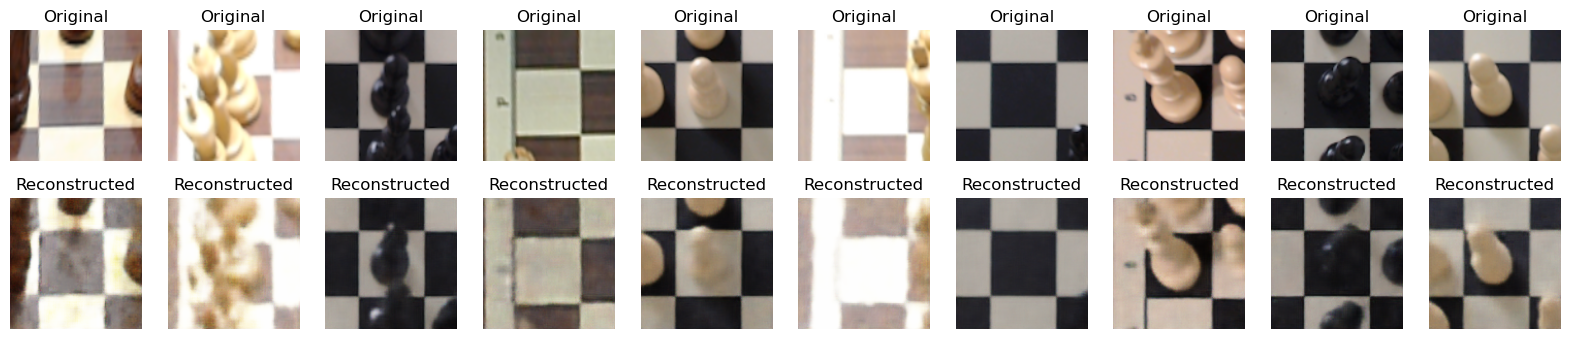

In [49]:
# Plot original and reconstructed images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


# Plot the high error samples
plot_images(high_error_images, reconstructed_images)


In [50]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 96)      2688      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 96)      384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        55360     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256 

In [51]:
# Function to extract features (latent space representations) from the dataset
def extract_latent_space(dataset, encoder):
    latent_space = []
    for batch in dataset:
        images = batch[0]
        encoded_batch = encoder.predict(images)
        latent_space.append(encoded_batch)
    latent_space = np.concatenate(latent_space, axis=0)
    return latent_space

# Extract features from the full dataset
latent_space = extract_latent_space(combined_dataset, encoder)

print("Latent space shape:", latent_space.shape)

1/1 [==============================] - 0s 9ms/step


2024-08-27 19:30:31.947246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


2024-08-27 19:31:03.858576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step
Latent space shape: (43408, 150)


In [52]:
print("Latent space shape:", latent_space.shape)
print("Contains NaN:", np.isnan(latent_space).any())
print("Contains infinite:", np.isinf(latent_space).any())


Latent space shape: (43408, 150)
Contains NaN: False
Contains infinite: False


In [54]:
from sklearn.manifold import TSNE
import seaborn as sns

1357/1357 [==============================] - 10s 7ms/step


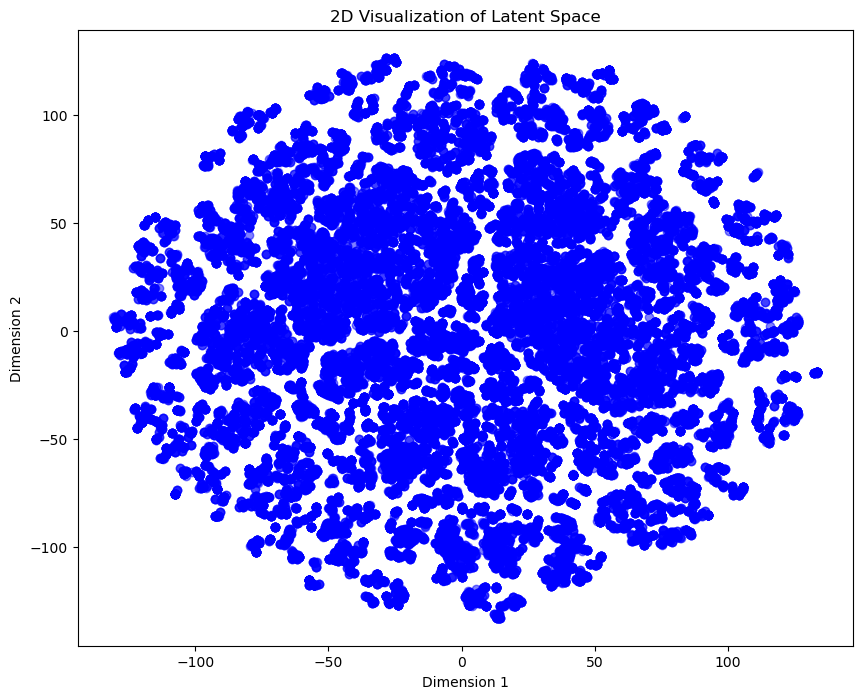

In [56]:
# Encode the data
encoded_data = encoder.predict(combined_dataset)

# Use t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2)
encoded_data_2d = tsne.fit_transform(encoded_data)

# Plot the encoded data
# Plot the encoded data without labels
plt.figure(figsize=(10, 8))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c='blue', alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [68]:
# Extract one batch of images from the combined dataset (train + val)
sample_batch = next(iter(combined_dataset))

# Extract one image from the batch
sample_image = sample_batch[0][0]  # First image in the batch



2024-08-27 19:53:53.559688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


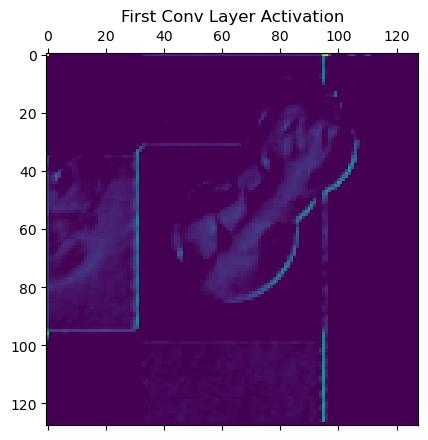

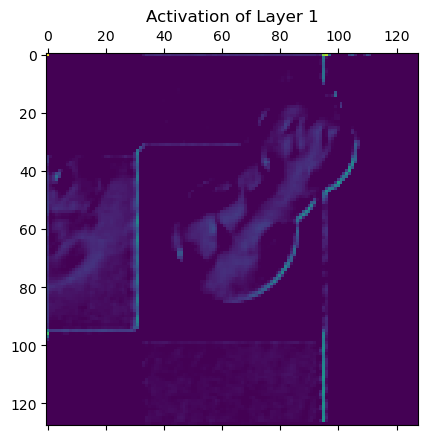

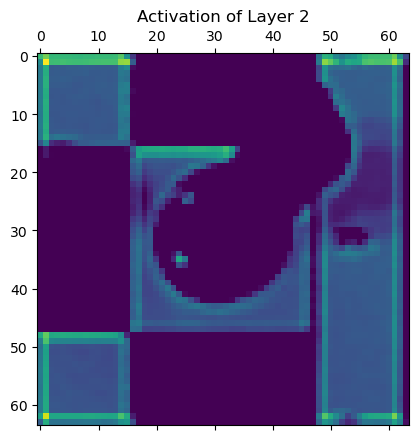

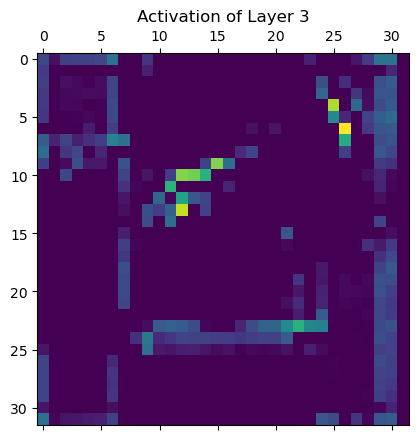

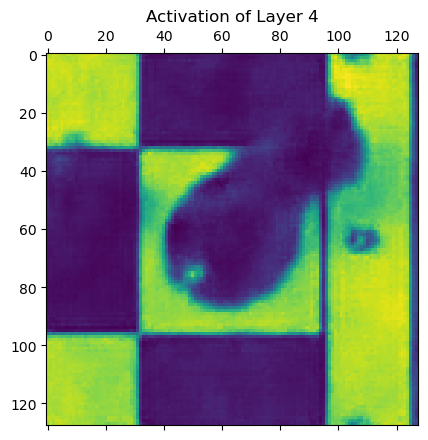

In [69]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

# Ensure the image has the correct shape, adding batch dimension if necessary
sample_image = tf.expand_dims(sample_image, axis=0)

# Extract outputs from the convolutional layers you want to visualize
layer_outputs = [
    best_autoencoder.get_layer('conv2d_12').output,
    best_autoencoder.get_layer('conv2d_13').output,
    best_autoencoder.get_layer('conv2d_14').output,
    best_autoencoder.get_layer('conv2d_15').output

]

# Create a model that returns the outputs of the specified layers
activation_model = models.Model(inputs=best_autoencoder.input, outputs=layer_outputs)

# Get the activations for the sample image
activations = activation_model.predict(sample_image)

# Visualize the activations of the first convolutional layer
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.title("First Conv Layer Activation")
plt.show()

# Visualize activations for additional layers
for i, activation in enumerate(activations):
    plt.matshow(activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Activation of Layer {i+1}")
    plt.show()



1/1 [==============================] - 0s 72ms/step


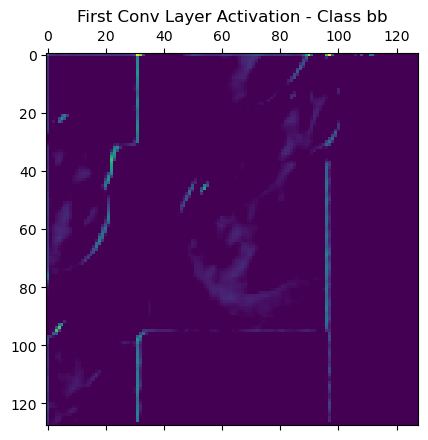

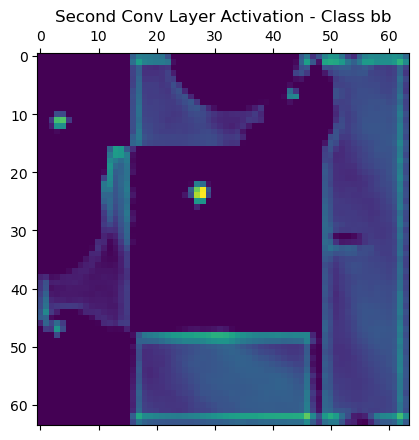

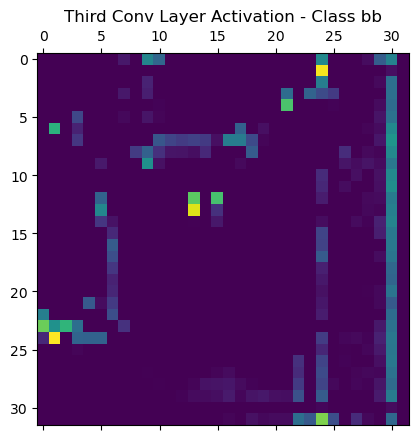

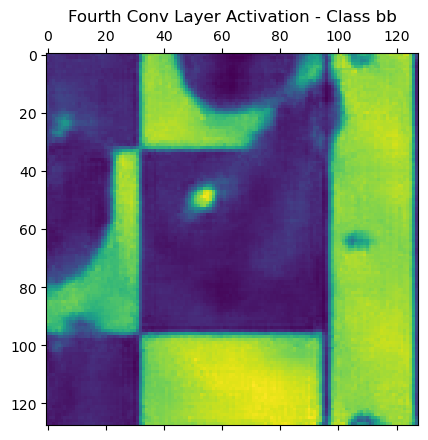

1/1 [==============================] - 0s 21ms/step


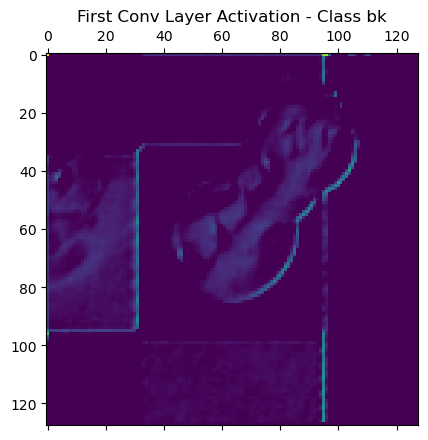

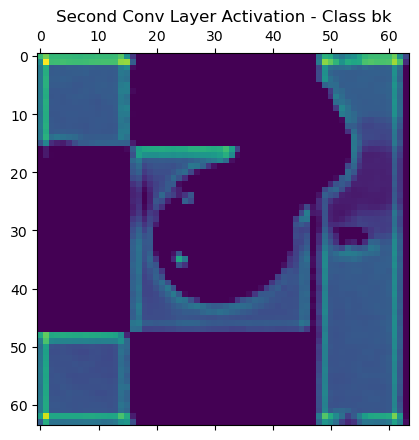

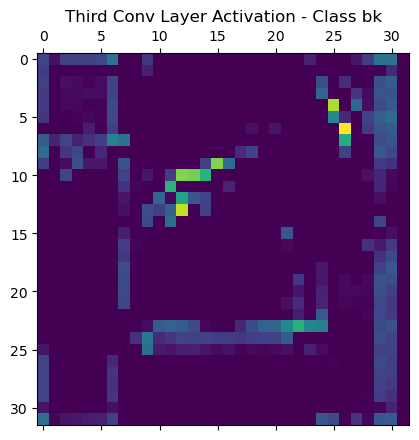

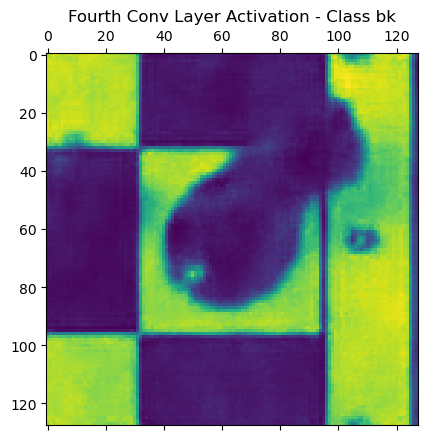

1/1 [==============================] - 0s 20ms/step


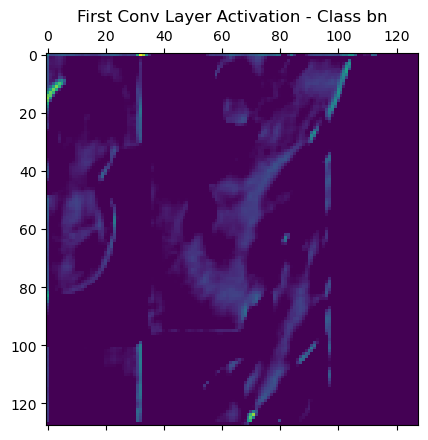

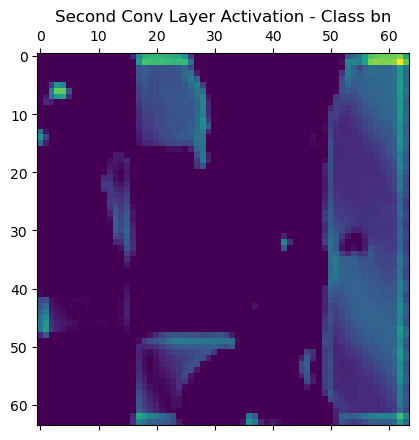

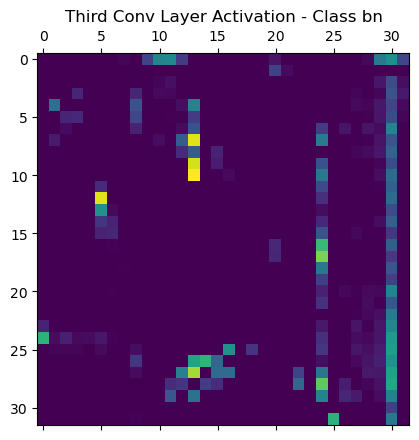

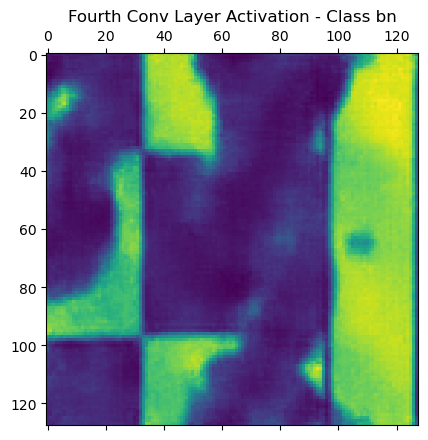

In [71]:
# Iterate through images from different classes
for class_name in ['bb', 'bk', 'bn']:  # Add more classes as needed
    # Find one image from each class
    class_image_path = [path for path in train_paths if class_name in path][0]
    class_image = load_image(class_image_path)

    # Expand dimensions to match model input
    class_image = tf.expand_dims(class_image, axis=0)

    # Get activations
    activations = activation_model.predict(class_image)

    # Visualize activations
    first_layer_activation = activations[0]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"First Conv Layer Activation - Class {class_name}")
    plt.show()


    # Visualize activations
    first_layer_activation = activations[1]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Second Conv Layer Activation - Class {class_name}")
    plt.show()


     # Visualize activations
    first_layer_activation = activations[2]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Third Conv Layer Activation - Class {class_name}")
    plt.show()


     # Visualize activations
    first_layer_activation = activations[3]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Fourth Conv Layer Activation - Class {class_name}")
    plt.show()